# Setup

In [1]:
# pip install pytorch_pretrained_bert pytorch-nlp

In [2]:
import sys
import numpy as np
import random as rn
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

In [3]:
rn.seed(10)
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# News Aggregator Dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

# keras: for data processing
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

/home/taeyong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/taeyong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
# data load
data = pd.read_csv('./data/uci_news_aggregator.csv', delimiter = ',', skiprows = 1,
                   names = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY',
                            'HOSTNAME', 'TIMESTAMP'], usecols=['TITLE', 'CATEGORY'])

In [6]:
data = data.reindex(np.random.permutation(data.index))

In [7]:
data.shape

(422419, 2)

In [8]:
data.head(20)

,TITLE,CATEGORY
207842,Dow and S&P 500 index close at record levels,b
223144,U.S. Consumer Price Inflation Accelerates In A...,b
329274,Broadway Will Dim Its Marquee Lights for Mary ...,e
90363,No real change in childhood obesity rates,m
215176,Newly-unveiled footage from 1937 shows FDR wal...,e
30170,Some missing bitcoins are found,b
245057,Home / Niederauer to resign as NYSE CEO,b
60944,GM ignition switch recall expands,b
249542,Piketty: FT's criticism 'ridiculous',b
15711,German deputy finance minister greets court ru...,b


In [9]:
# data slicing
num_of_categories = 12500
shuffled = data.reindex(np.random.permutation(data.index))

e = shuffled[shuffled['CATEGORY'] == 'e']#[:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b']#[:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't']#[:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm']#[:num_of_categories]

concated = pd.concat([e,b,t,m], ignore_index=True)

In [10]:
# label col
concated['LABEL'] = 0

In [11]:
np.random.seed(41)
concated = concated.reindex(np.random.permutation(concated.index))

concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3

In [12]:
concated['LABEL'][:10]

51683     0
364094    2
220239    1
15418     0
162428    1
346459    2
60046     0
331513    2
7953      0
78829     0
Name: LABEL, dtype: int64

In [13]:
# one-hot encoding
labels = to_categorical(concated['LABEL'], num_classes=4)

In [14]:
labels

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

# BERT Tokenizer

In [15]:
word_max_len = 64

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [17]:
 concated['TITLE'].values[:3]

array(["Georgina Haig Joins 'Once Upon A Time' as Queen Elsa",
       'Stolen social insurance numbers can cause many problems',
       "Will Twitter's Q1 earnings meet Wall Street expectations?"],
      dtype=object)

In [18]:
tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t) + ['[SEP]'], concated['TITLE'].values))

In [19]:
tokens[:3]

[['[CLS]',
  'georgina',
  'hai',
  '##g',
  'joins',
  "'",
  'once',
  'upon',
  'a',
  'time',
  "'",
  'as',
  'queen',
  'elsa',
  '[SEP]'],
 ['[CLS]',
  'stolen',
  'social',
  'insurance',
  'numbers',
  'can',
  'cause',
  'many',
  'problems',
  '[SEP]'],
 ['[CLS]',
  'will',
  'twitter',
  "'",
  's',
  'q',
  '##1',
  'earnings',
  'meet',
  'wall',
  'street',
  'expectations',
  '?',
  '[SEP]']]

In [20]:
tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokens)), maxlen=word_max_len, truncating="post", padding="post", dtype="int")

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (11776 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1404 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (9657 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (7454 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1069 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence le

In [21]:
tokens_ids.shape

(422419, 64)

In [22]:
tokens_ids[:1]

array([[  101, 27358, 15030,  2290,  9794,  1005,  2320,  2588,  1037,
         2051,  1005,  2004,  3035, 23452,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])

In [23]:
masks = [[float(i > 0) for i in ii] for ii in tokens_ids]

In [24]:
masks[:1]

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

# BERT Baseline

In [25]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
#         proba = self.sigmoid(linear_output)
        proba = self.softmax(linear_output)
        return proba

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
device

device(type='cuda')

In [28]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [29]:
bert_clf = BertClassifier()

In [30]:
bert_clf = bert_clf.cuda()

In [31]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.074304M'

In [32]:
x = torch.tensor(tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)

In [33]:
x.shape, y.shape, pooled.shape

(torch.Size([3, 64]), torch.Size([3, 64, 768]), torch.Size([3, 768]))

In [34]:
x

tensor([[  101, 27358, 15030,  2290,  9794,  1005,  2320,  2588,  1037,  2051,
          1005,  2004,  3035, 23452,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  7376,  2591,  5427,  3616,  2064,  3426,  2116,  3471,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0

In [35]:
y

tensor([[[-2.8207e-01,  2.4838e-01,  5.8646e-01,  ..., -3.5017e-01,
           1.0009e-01, -2.6468e-01],
         [-4.0030e-02,  4.1529e-01,  5.6553e-01,  ..., -3.4315e-01,
           3.8762e-01, -5.5785e-01],
         [ 6.3444e-01,  4.2569e-01,  9.9663e-01,  ...,  2.9993e-01,
           7.6073e-01,  8.5302e-01],
         ...,
         [-2.2172e-02, -1.5674e-02,  6.6832e-01,  ..., -4.5963e-01,
           9.9788e-02, -7.3225e-01],
         [ 2.8428e-03, -5.7244e-02,  8.5414e-01,  ..., -5.1558e-01,
           9.4784e-02, -4.8146e-01],
         [ 8.3657e-03, -2.8630e-01,  8.9913e-01,  ..., -6.5501e-01,
           1.1099e-01, -2.4487e-01]],

        [[-2.0049e-01,  2.1620e-01,  7.0347e-01,  ..., -3.1311e-01,
           5.7537e-01, -2.0779e-01],
         [ 5.1083e-01, -5.9955e-02,  8.7744e-01,  ..., -2.5219e-01,
          -2.4464e-01, -2.3501e-01],
         [ 2.9611e-01, -2.2467e-01,  7.1730e-01,  ..., -4.8486e-01,
          -1.3786e-01, -6.7392e-01],
         ...,
         [ 5.6809e-02, -4

In [36]:
pooled

tensor([[-0.5156, -0.3123, -0.6917,  ..., -0.0835, -0.5205,  0.6408],
        [-0.4346, -0.3995, -0.7330,  ..., -0.1952, -0.5318,  0.5257],
        [-0.4422, -0.2517, -0.6401,  ..., -0.1717, -0.4710,  0.4387]],
       device='cuda:0', grad_fn=<TanhBackward>)

In [37]:
y = bert_clf(x)

/home/taeyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [38]:
y.cpu().detach().numpy()

array([[0.31779057, 0.16687712, 0.16944495, 0.34588736],
       [0.3085278 , 0.24000305, 0.20457213, 0.24689703],
       [0.30087715, 0.2129052 , 0.17448093, 0.3117367 ]], dtype=float32)

In [39]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'894.48704M'

In [40]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()

In [41]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'667.20768M'

# Fine-tune BERT

- Train / Test

In [42]:
BATCH_SIZE = 3
EPOCHS = 3

In [43]:
split_size = 4 * int(len(tokens_ids) / 5)

In [44]:
X_train_ids, X_test_ids = tokens_ids[:split_size,:], tokens_ids[split_size:,:]

In [45]:
tokens_ids.shape

(422419, 64)

In [46]:
X_train_ids.shape

(337932, 64)

In [47]:
X_test_ids.shape

(84487, 64)

In [48]:
y_train, y_test = labels[:split_size,:], labels[split_size:,:]

In [49]:
labels.shape

(422419, 4)

In [50]:
y_train.shape

(337932, 4)

In [51]:
y_test.shape

(84487, 4)

In [52]:
masks_train, masks_test = np.array(masks)[:split_size,:], np.array(masks)[split_size:,:]

In [53]:
np.array(masks).shape

(422419, 64)

In [54]:
masks_train.shape

(337932, 64)

In [55]:
masks_test.shape

(84487, 64)

In [56]:
train_tokens_tensor = torch.tensor(X_train_ids)
train_y_tensor = torch.tensor(y_train).float()

test_tokens_tensor = torch.tensor(X_test_ids)
test_y_tensor = torch.tensor(y_test).float()

train_masks_tensor = torch.tensor(masks_train)
test_masks_tensor = torch.tensor(masks_test)

In [57]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'667.20768M'

In [58]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [59]:
len(train_dataloader)

112644

In [60]:
len(test_dataloader)

28163

In [61]:
train_dataset.tensors

(tensor([[  101, 27358, 15030,  ...,     0,     0,     0],
         [  101,  7376,  2591,  ...,     0,     0,     0],
         [  101,  2097, 10474,  ...,     0,     0,     0],
         ...,
         [  101,  6106,  2015,  ...,     0,     0,     0],
         [  101, 13753,  3976,  ...,     0,     0,     0],
         [  101,  8861,  2402,  ...,     0,     0,     0]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([[1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         ...,
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]]))

- Fine-tune BERT

In [62]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [63]:
torch.cuda.empty_cache()

In [64]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        bert_clf.zero_grad()
        batch_loss.backward()

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, int(len(X_train_ids) / BATCH_SIZE), train_loss / (step_num + 1)))

Epoch:  3
112643/112644 loss: 0.06198843557304419 


In [65]:
torch.save(bert_clf, './bert_clf_' + str(EPOCHS) + 'epoch' + '.h5')

/home/taeyong/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type BertClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Evaluation

In [66]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()
        
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        for i in range(len(logits)):
             bert_predicted.append(logits[i].argmax())
#         bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])
        
        clear_output(wait=True)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, int(len(X_test_ids) / BATCH_SIZE), train_loss / (step_num + 1)))

28162/28162 loss: 0.24793613381706459 


In [69]:
bert_predicted = np.array(bert_predicted)

In [70]:
len(bert_predicted)

84487

In [71]:
bert_predicted

array([tensor(0, device='cuda:0'), tensor(0, device='cuda:0'),
       tensor(2, device='cuda:0'), ..., tensor(2, device='cuda:0'),
       tensor(0, device='cuda:0'), tensor(2, device='cuda:0')],
      dtype=object)

In [72]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]])

- Accuracy of classification

In [73]:
correct_count = 0
for i in range(len(bert_predicted)):
    y = y_test[i].argmax()
    
    if bert_predicted[i].item() == y:
        correct_count = correct_count + 1

In [74]:
correct_count / len(bert_predicted)

0.962325564879804

- Confusion matrix

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [76]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [77]:
class_names = np.array(['B', 'E', 'T', 'M'])

In [78]:
confusion_matrix_predicted = [element.item() for element in bert_predicted.flatten()]

In [79]:
confusion_matrix_predicted

[0,
 0,
 2,
 3,
 0,
 1,
 2,
 1,
 1,
 3,
 2,
 3,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 3,
 1,
 2,
 0,
 0,
 1,
 3,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 3,
 0,
 1,
 2,
 2,
 0,
 3,
 0,
 1,
 0,
 1,
 2,
 2,
 2,
 0,
 1,
 3,
 1,
 2,
 0,
 3,
 0,
 3,
 1,
 0,
 0,
 0,
 1,
 1,
 3,
 2,
 1,
 0,
 3,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 2,
 3,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 3,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 3,
 3,
 1,
 2,
 2,
 1,
 0,
 0,
 3,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 1,
 0,
 3,
 1,
 0,
 1,
 2,
 1,
 0,
 3,
 1,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 3,
 2,
 3,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 3,
 3,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 3,
 1,
 0,
 2,
 0,
 2,
 3,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 0,
 2,
 3,
 1,
 1,
 3,
 2,
 2,
 0,
 0,
 0,
 1,
 0,
 2,
 0,


In [80]:
y_test.argmax(axis=1)

array([0, 0, 2, ..., 2, 0, 2])

Normalized confusion matrix
[[0.98230992 0.00882857 0.0065226  0.00233891]
 [0.00698282 0.94709335 0.03919805 0.00672579]
 [0.00748544 0.03479346 0.9549025  0.00281859]
 [0.01202712 0.02667833 0.00885633 0.95243822]]


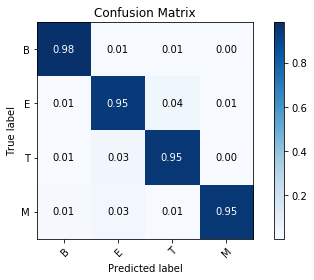

In [81]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), confusion_matrix_predicted, classes=class_names, normalize=True,
                      title='Confusion Matrix')

plt.show()